<a href="https://colab.research.google.com/github/GaneshM2714/Tumor_Detection_ml/blob/main/Parat_Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [2]:
def crop_brain_contour(image, plot=False):

    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

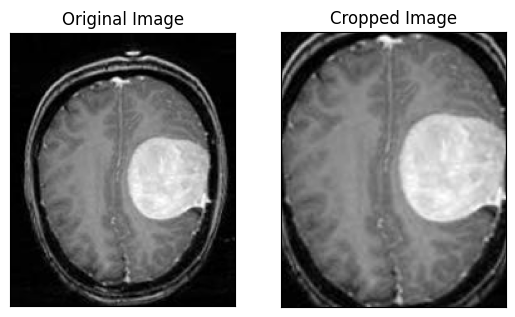

In [3]:
ex_img = cv2.imread('yes/aug_Y1_0_2900.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [6]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [7]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data(['yes', 'no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input

In [9]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)


In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [11]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming X_train, X_val, y_train, y_val are already defined as numpy arrays
input_shape = X_train.shape[1:]  # Shape of input images

# Define a CNN model
model = models.Sequential([
    # Convolutional Layer with regularization
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, kernel_size=(3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Assuming binary classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [14]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=2
)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/30
46/46 - 20s - 438ms/step - accuracy: 0.5813 - loss: 0.8248 - val_accuracy: 0.7258 - val_loss: 0.6746
Epoch 2/30
46/46 - 3s - 62ms/step - accuracy: 0.7682 - loss: 0.5756 - val_accuracy: 0.7290 - val_loss: 0.5755
Epoch 3/30
46/46 - 5s - 108ms/step - accuracy: 0.8256 - loss: 0.4642 - val_accuracy: 0.7806 - val_loss: 0.5325
Epoch 4/30
46/46 - 5s - 111ms/step - accuracy: 0.8388 - loss: 0.4200 - val_accuracy: 0.8387 - val_loss: 0.4279
Epoch 5/30
46/46 - 5s - 112ms/step - accuracy: 0.8740 - loss: 0.3572 - val_accuracy: 0.8290 - val_loss: 0.4481
Epoch 6/30
46/46 - 3s - 58ms/step - accuracy: 0.8997 - loss: 0.2896 - val_accuracy: 0.8581 - val_loss: 0.4124
Epoch 7/30
46/46 - 5s - 112ms/step - accuracy: 0.9093 - loss: 0.2666 - val_accuracy: 0.8581 - val_loss: 0.4029
Epoch 8/30
46/46 - 3s - 61ms/step - accuracy: 0.9301 - loss: 0.2094 - val_accuracy: 0.8613 - val_loss: 0.3590
Epoch 9/30
46/46 - 3s - 58ms/step - accuracy: 0.9509 - loss: 0.1787 - val_accuracy: 0.8677 - val_loss: 0.3910
Epoc

In [19]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Assuming y_test and y_pred are your true and predicted labels
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:",  f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8193548387096774
Precision: 0.8717948717948718
Recall: 0.7906976744186046
F1-score: 0.8292682926829268
Confusion Matrix:
 [[118  20]
 [ 36 136]]


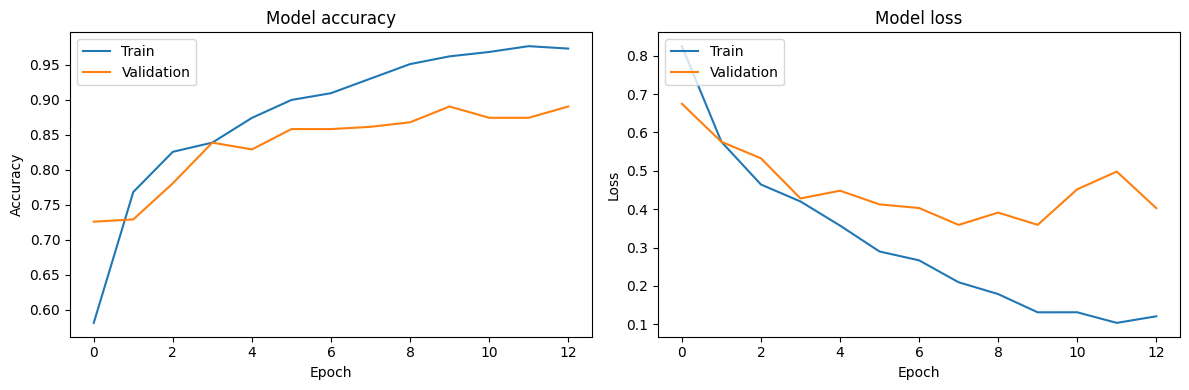

In [21]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable returned by model.fit()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))  # Adjust figure size as needed

plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [23]:
model.save('TumorDetector.keras')